## Implementación del algoritmo de Kittler


In [53]:
import torch

In [54]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

In [55]:
U_1 = torch.tensor(
    np.array(Image.open('input/C4_02_1_1_DAPI_001.bmp').convert('L')))

output_path = "salida.png"
#example for writing image
Y = torch.zeros(U_1.shape)
print(Y)
Y_pil = Image.fromarray(Y.numpy().astype(np.uint8))
Y_pil.save(output_path)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [56]:
def get_image_tensor(path='input/cuadro1_005.bmp'):
  return torch.tensor(
      np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

In [57]:
def pre_process_tensor(image_tensor):
  return image_tensor.flatten().float()

In [58]:
data = pre_process_tensor(get_image_tensor())
print("Shape of tensor:", data.shape[0])
print(data)

Shape of tensor: 343980
tensor([219., 218., 219.,  ..., 221., 225., 224.])


In [59]:
def get_histogram(data, pdf=False):
  #hist_x = torch.histogram(data, bins=torch.unique(data, sorted=True),
  #                     min=data.min().item(), max=data.max().item())
  histogram, bin_edges = torch.histogram(
      data, bins=torch.unique(data, sorted=True).numel())
  
  N = data.shape[0]

  p_gaussian = histogram / N
  x_axis = torch.unique(data, sorted=True)

  return x_axis, histogram, p_gaussian

In [60]:
def get_histogram_2(data):

  #calculate histogram
  #number of bins: number of bins within the range
  histogram_gaussian, bins_gaussian = np.histogram(gaussian_sample.numpy(), bins = 20, range = (0, 20))
  #normalize the histogram to estimate a density function
  p_gaussian = torch.tensor(histogram_gaussian / histogram_gaussian.sum())

  return histogram_gaussian, p_gaussian
  

In [61]:
import torch


def get_histogram(data, pdf=False):
    unique_values, counts = torch.unique(data, return_counts=True)
    total_samples = data.shape[0]

    probabilities = counts.float() / total_samples
    return unique_values, counts, probabilities
    

# Create an array for testing
test_array = torch.tensor(
    [1., 2., 3., 1., 2., 5., 6., 3., 4., 5., 6., 7., 8., 9., 8., 7., 4., 3., 2., 1.])

# Test the function
x_axis, histogram, p_gaussian = get_histogram(test_array)

print("Unique Values (x_axis):", x_axis)
print("Histogram:", histogram)
print("Probability Density Function:", p_gaussian)

Unique Values (x_axis): tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])
Histogram: tensor([3, 3, 3, 2, 2, 2, 2, 2, 1])
Probability Density Function: tensor([0.1500, 0.1500, 0.1500, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.0500])


### Calculo de Momentos Estadisticos

Implemente una funcion `calcular_momentos_estadisticos(T,p)` la cual reciba un umbral candidato *T* y una funcion de densidad *p*, y retorne todos los parametros de la función. Comente su implementacion con detalle en este informe


Este p es el mixto gasusiano (p, media 1, media 2, std, 1, std 2, P1, P2)

In [62]:
def calculate_p1(x, pdf, T):
    index = (x > T).nonzero()[0].item()
    #index -= 1
    index = 0 if index < 0 else index
    x1 = x[:index]
    pdf1 = pdf[:index]
    p1 = pdf[:index].sum().item()
    return x1, pdf1, p1

def calculate_p2(x, pdf, T):
    index = (x > T).nonzero()[0].item()
    #index -= 1
    x2 = x[index:]
    pdf2 = pdf[index:]
    p2 = pdf[index:].sum().item()

    return x2, pdf2, p2

In [63]:
def calculate_mu(x, pdf, p):
  mu = 0

  for i in range(len(x)):
    mu += (x[i].item() * pdf[i].item())
  
  return mu / p

In [64]:
def calculate_sigma(x, mu, pdf, p):
    variance = 0
    for i in range(len(x)):
        variance += pdf[i].item() * ((x[i].item() - mu) ** 2)
    return variance / p

In [65]:
def calculate_statistics(T, x, pdf):
  x1, pdf1, p1 = calculate_p1(x, pdf, T)
  x2, pdf2, p2 = calculate_p2(x, pdf, T)

  mean_1 = calculate_mu(x1, pdf1, p1)
  mean_2 = calculate_mu(x2, pdf2, p2)

  sigma_1 = calculate_sigma(x1, mean_1, pdf1, p1)
  sigma_2 = calculate_sigma(x2, mean_2, pdf2, p2)

  return mean_1, mean_2, sigma_1, sigma_2, p1, p2

In [88]:
import torch

def assert_values(x, y, tolerance):
    x_rounded = round(x, 3)
    y_rounded = round(y, 3)
    try:
        assert abs(x_rounded - y_rounded) <= tolerance
    except AssertionError:
        print(f"Test failed: calculated={x_rounded}, expected={y_rounded}, difference={abs(x_rounded - y_rounded)}")
    else:
        print(f"Test passed: calculated={x_rounded}, expected={y_rounded}, difference={abs(x_rounded - y_rounded)}")


def test_calculate_statistics(tolerance=10):
    test_array_1 = torch.tensor([2.0, 2.0, 2.0, 1., 3.])
    test_array_2 = torch.tensor([10., 10., 17., 13., 13., 13., 30])

    exp_mean_1 = test_array_1.mean().item()
    exp_var_1 = test_array_1.var().item()
    exp_mean_2 = test_array_2.mean().item()
    exp_var_2 = test_array_2.var().item()

    concatenated_tensor = torch.cat((test_array_1, test_array_2), dim=0)
    x_axis, histogram, p_gaussian = get_histogram(concatenated_tensor)
    mean_1, mean_2, sigma_1, sigma_2, p_1, p_2 = calculate_statistics(5, x_axis,p_gaussian)

    assert_values(mean_1, exp_mean_1, tolerance)
    assert_values(mean_2, exp_mean_2, tolerance)
    assert_values(sigma_1, exp_var_1, tolerance)
    assert_values(sigma_2, exp_var_2, tolerance)

test_calculate_statistics()


Test passed: calculated=2.0, expected=2.0, difference=0.0
Test passed: calculated=15.143, expected=15.143, difference=0.0
Test passed: calculated=0.4, expected=0.5, difference=0.09999999999999998
Test passed: calculated=41.551, expected=48.476, difference=6.924999999999997


### Calcular Costo

Implemente la función calcular_costo_J(T) la cual calcule el costo del umbral candidato T. Comente su implementacion con detalle en este informe.

In [67]:
def error_function(x, t, mu, sigma, P):
  i = 0 if x < t else 1

  error = ((x - mu[i]) / sigma[i])**2 + (2*np.log(mu[i])) - (2*np.log(P[i]))

  return error

In [68]:
# ver si se puede usar sin fors

def calculate_cost(x_axis, pdf_y, t, mu, sigma, P):
  cost = 0
  for i in range(len(x_axis)):
    cost += pdf_y[i] * error_function(x_axis[i], t, mu, sigma, P)

  return cost

In [ ]:
def calculate_cost_2(t, sigma_1, sigma_2, p_1, p_2):
  cost = 1 + 2[p_1*torch.log(sigma_1) + p_2*torch.log(sigma_2)] - 2[p_1*torch.log(p_1) + p_2*torch.log(p_2)]
  return cost

### Calculo T Optimo

Basado en ambas funciones, implemente la función calcular_T_optimo_Kittler(Imagen) la cual retorne el T optimo para umbralizar la imagen recibida, además de la imagen umbralizada.

### Aplicación del Algoritmo de Kittler

Aplique el algoritmo de Kittler en la imagen cuadro1_005.bmp, pro-
vista

#### Graficación del histograma
Grafique el histograma normalizado de la imagen de entrada
provista

In [69]:
def get_image_tensor(path='input/cuadro1_005.bmp'):
  return torch.tensor(
      np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

In [70]:
def pre_process_tensor(image_tensor):
  return image_tensor.flatten().float()

In [71]:
data = pre_process_tensor(get_image_tensor())
print("Shape of tensor:", data.shape[0])
print(data)

Shape of tensor: 343980
tensor([219., 218., 219.,  ..., 221., 225., 224.])


In [72]:
def plot_histogram(data, title="Histogram", pdf=False):
  _, hist, y_axis = get_histogram(data, pdf)
  y_label = "Frecuency" if not pdf else "Probabilities"

  plt.bar(data.unique().numpy(), hist, width=0.5, align='center')
  plt.xlabel('Values')
  plt.ylabel(y_label)
  plt.title(title)
  plt.grid(True)
  plt.show()

In [73]:
#plot_histogram([2.0, 2.0, 2.0, 10., 10., 10., 13., 13., 13.])

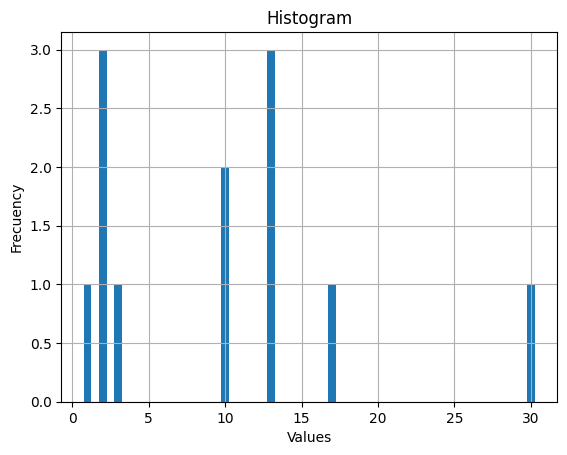

In [74]:
plot_histogram(test_array_complete)

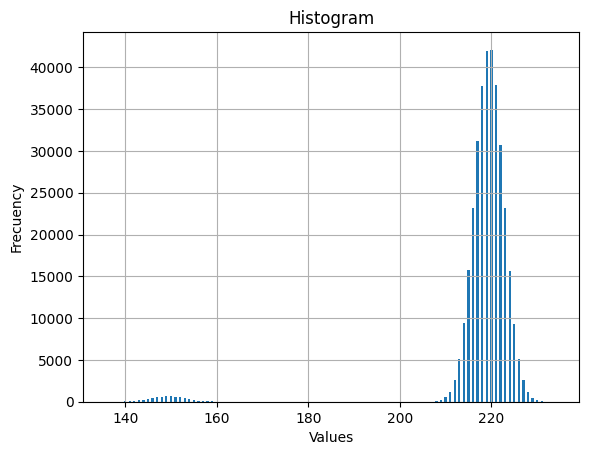

In [75]:
plot_histogram(data)

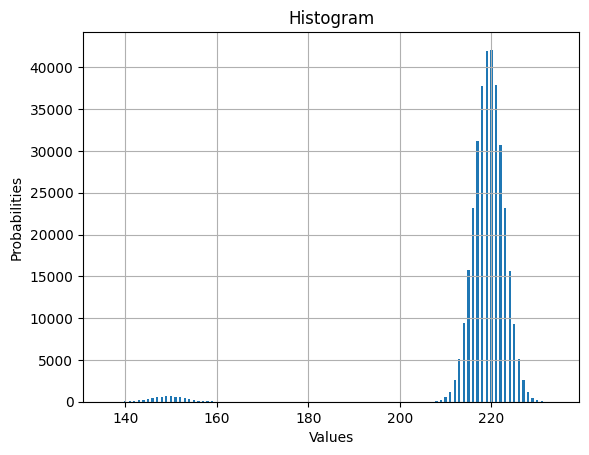

In [76]:
plot_histogram(data, pdf=True)

In [77]:
hist_x, pdf_y = get_histogram(data, pdf=True)

print("Proof of normalization:", pdf_y.sum().item())

ValueError: too many values to unpack (expected 2)

In [ ]:
len(hist_x)

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt


def plot_kde(data_tensor, title='Kernel Density Estimation (KDE) Plot'):
    data_np = data_tensor.numpy()
    sns.kdeplot(data_np, fill=True, legend=False)
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
plot_kde(data)

### Distancia de Bhattacharyaa

Implemente la funcion´ calcular bhattacharyya distance(p,q), para comparar las funciones de densidad estimada con el ajuste del modelo mixto Gaussiano con Kittler p (x) y la aproximacion de la densidad
con el histograma de los datos q (x) para las dos pruebas realizadas
con la imagen y el audio.


In [ ]:
#Estamos asumiendo que p y q son los valores de probabilidad, se puede depurar para que solo vengan las funciones y se calcula


def bhattacharyya_distance(p, q):
    device = p.device

    sqrt_product = torch.sqrt(p * q)
    sum_sqrt_product = torch.sum(sqrt_product)
    distance = -torch.log(sum_sqrt_product)

    return distance.item()

# Example usage:
p = torch.tensor([0.2, 0.3, 0.5])
q = torch.tensor([0.2, 0.3, 0.5])

distance = bhattacharyya_distance(p, q)
print("Bhattacharyya distance:", distance)

In [ ]:
p = torch.tensor([0.2, 0.3, 0.5])
q = torch.tensor([0.2, 3.0])

p = p[:len(q)]
p

In [ ]:
hist_x_left, pdf_y_left = get_histogram(data, pdf=True, threshold=180, left_t=True)
hist_x_right, pdf_y_right = get_histogram(data, pdf=True, threshold=180, left_t=False)

In [ ]:
result = pdf_y_right.sum() + pdf_y_left.sum()
result

In [ ]:
len(hist_x_right)

In [ ]:
len(hist_x_left)